# [Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

# **Genre Prediction**


# Frame The Problem And Look At The Big Picture

1. ***Define the objective in business terms***:

- The goal of this project is to build a system that can classify music genres based on audio features extracted from songs. For this, we’re using the GTZAN dataset, which contains tracks labeled across 10 genres, such as Blues, Jazz, Rock, and Classical. The project involves analyzing the dataset to uncover patterns in the audio features that can help distinguish one genre from another. This work has practical applications in many areas. For example, music streaming platforms could use a system like this to improve their recommendation algorithms by better understanding the genres of songs. It could also help organize large music libraries by automatically tagging tracks with the correct genre, saving time and reducing human errors. Beyond that, it could provide insights into genre trends, which could be useful for the music industry in understanding listener preferences and market dynamics. Our ultimate goal is to develop a system that is both accurate and insightful, demonstrating the potential of audio-based classification for real-world use cases. Along the way, we’ll focus on understanding how audio features correlate with genre characteristics and how to improve the system’s accuracy through experimentation and optimization.

2. ***How will your solution be used***:
- Music streaming platforms could integrate it into their recommendation systems
- Music libraries could use it for automated genre tagging
- Music industry analysts could use it to study genre trends and market dynamics
- Could be used in real-time (for live genre classification) or batch processing (for library organization)

3. ***Current solutions/workarounds***:
- Manual genre tagging by music experts
- Existing audio classification like https://www.submithub.com/whats-my-genre

4. ***Problem framing***:
- This is a supervised learning problem as we have labeled data (songs with known genres)
- It's a multi-class classification task (10 different genres)
- Can be implemented as either online (real-time) or offline (batch) depending on the use case
- The GTZAN dataset provides labeled training data

5. ***Performance measurement***:
- Classification metrics like accuracy, precision, recall, and F1-score
- Confusion matrix to understand misclassifications between genres
- Below shows we're using `recall_macro` as the scoring metric for GridSearchCV
- `recall_macro` is a scoring metric used to evaluate the performance of a multi-class classification model. It calculates the recall for each class separately and then computes the unweighted (arithmetic) average of those recall values across all classes.
- Cross-validation scores to ensure robust performance

6. ***Minimum performance needed***:
- Highest accuracy possible, As many songs should be assigned their correct label as possible.
- Prioritizing: Recall

7. ***Comparable problems***:
- Speech recognition
- Sound classification
- Audio fingerprinting
- Music mood classification
- Artist identification from audio  
These all use similar audio feature extraction and classification techniques

8. ***Human expertise availability***:
- Music experts can manually classify genres
- Domain knowledge about audio features and their relationship to genres is available (as shown in the feature descriptions)

9. ***Manual solution process***:  
A human would:
- Listen to the audio
- Identify key characteristics like:
  - Instruments used
  - Rhythm patterns
  - Tempo
  - Vocal style
  - Harmonic structure
- Compare these characteristics against known genre conventions
- Make a classification based on overall similarity to genre patterns

10. ***Assumptions made***:
- The 10 genres in GTZAN dataset are sufficient to represent music diversity
- 30-second segments are enough to determine genre
- The dataset is representative of real-world music
- The genre labels in the training data are accurate

These assumptions could be verified by:
- Validating genre labels with multiple music experts
- Testing the model on more recent music releases

# **Get The Data**

#### Imports:

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading the data:

In [82]:
# Function to load the dataset
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

In [83]:
sec_data = load_dataset('features_3_sec.csv')
data = load_dataset('features_30_sec.csv')

### Found Jazz #54 is corrupted

In [84]:
import os
import pandas as pd
import librosa
import numpy as np
import soundfile as sf

def extract_features(y, sr):
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()
    chroma_stft_var = librosa.feature.chroma_stft(y=y, sr=sr).var()
    rms = librosa.feature.rms(y=y).mean()
    rms_var = librosa.feature.rms(y=y).var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spectral_centroid_var = librosa.feature.spectral_centroid(y=y, sr=sr).var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_bandwidth_var = librosa.feature.spectral_bandwidth(y=y, sr=sr).var()
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    rolloff_var = librosa.feature.spectral_rolloff(y=y, sr=sr).var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y).mean()
    zero_crossing_rate_var = librosa.feature.zero_crossing_rate(y=y).var()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_means = mfcc.mean(axis=1)
    mfcc_vars = mfcc.var(axis=1)
    return [
        chroma_stft, chroma_stft_var, rms, rms_var,
        spectral_centroid, spectral_centroid_var,
        spectral_bandwidth, spectral_bandwidth_var,
        rolloff, rolloff_var, zero_crossing_rate, zero_crossing_rate_var,
        *mfcc_means, *mfcc_vars
    ]

def split_and_process(file, output_dir, label, segment_duration=3):
    y, sr = librosa.load(file, sr=None)
    samples_per_segment = int(segment_duration * sr)
    for i, start_sample in enumerate(range(0, len(y), samples_per_segment)):
        end_sample = start_sample + samples_per_segment
        segment = y[start_sample:end_sample]
        
        if len(segment) < samples_per_segment:
            break
        
        output_filename = f"{os.path.splitext(os.path.basename(file))[0]}.{i}.wav"
        output_path = os.path.join(output_dir, output_filename)
        sf.write(output_path, segment, sr)

for file_name in data['filename']:
    input_file = f"./audio/{file_name.split('.')[0]}/{file_name}"
    output_directory = f"./audio/3_second/{file_name.split('.')[0]}"
    os.makedirs(output_directory, exist_ok=True)
    label = file_name.split('.')[0]
    try:
        split_and_process(input_file, output_directory, label)
    except Exception as e:
        print(f"Exception processing {input_file}: {e}")
    # print(f"Processed {input_file}")

Exception processing ./audio/jazz/jazz.00054.wav: 


In [85]:
print(data.columns)


Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [86]:
"""
import soundfile as sf
# Creating audio files for the 5 second increments

for i in range(0, len(data)):
    if i == 0:
        start = 0
    else:
        start = data.iloc[i-1]['end']
    end = data.iloc[i]['end']
    audio, sr = sf.read(f'data/UrbanSound8K/audio/fold{data.iloc[i]["fold"]}/{data.iloc[i]["slice_file_name"]}')
    sf.write(f'data/5_sec_audio/{data.iloc[i]["slice_file_name"]}', audio[int(start*sr):int(end*sr)], sr)

"""

'\nimport soundfile as sf\n# Creating audio files for the 5 second increments\n\nfor i in range(0, len(data)):\n    if i == 0:\n        start = 0\n    else:\n        start = data.iloc[i-1][\'end\']\n    end = data.iloc[i][\'end\']\n    audio, sr = sf.read(f\'data/UrbanSound8K/audio/fold{data.iloc[i]["fold"]}/{data.iloc[i]["slice_file_name"]}\')\n    sf.write(f\'data/5_sec_audio/{data.iloc[i]["slice_file_name"]}\', audio[int(start*sr):int(end*sr)], sr)\n\n'

In [87]:
sec_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues



#### *Data Overview*

- The dataset contains 2 sets of audio features including spectral measurements, MFCCs, and temporal characteristics with no missing values.
- One dataset containing 30 second samples and the corresponding values and the other 3 second samples, both have the same features
- The dataset contains 1000 30 second songs with 100 songs for each of the 10 genres in a `.wav` format.
- The dataset also contains a Mel Spectrogram corresponding to each of the songs.

| Feature | Description |
|---------|------------|
| chroma_stft | Represents pitch content by mapping spectral data into 12 pitch classes |
| rms | Root Mean Square energy - represents the loudness/volume of the audio |
| spectral_centroid | Indicates where the "center of mass" of the sound is - relates to sound brightness |
| spectral_bandwidth | Width of the spectrum - indicates the range of frequencies |
| rolloff | Frequency below which most of the signal's energy is contained |
| zero_crossing_rate | Rate at which the signal changes from positive to negative - relates to noisiness |
| harmony | Measure of harmonic content vs noise in the signal |
| perceptr | Perceptual features of the sound |
| tempo | Speed/pace of the music in beats per minute |
| mfcc1-20 | Mel-frequency cepstral coefficients - represent the overall shape of the spectral envelope |

Note: Each feature has both _mean and _var (variance) measurements, representing the average value and how much it varies throughout the audio sample.


- 1,000 entries with 60 columns
- All data fields are completely populated
- Data types:
  - float64: 57 columns (audio features)
  - int64: 1 column (length)
  - object: 2 columns (filename, label)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [89]:
data.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


### *Data Histograms*

- Looking at these histograms, most of the audio features (like pitch, volume, and frequency measurements) follow bell-shaped distributions centered around specific values, while the variance features (showing how much these measurements change) tend to have right-skewed distributions with long tails, meaning most songs have small variations but some have very large changes in their audio characteristics.

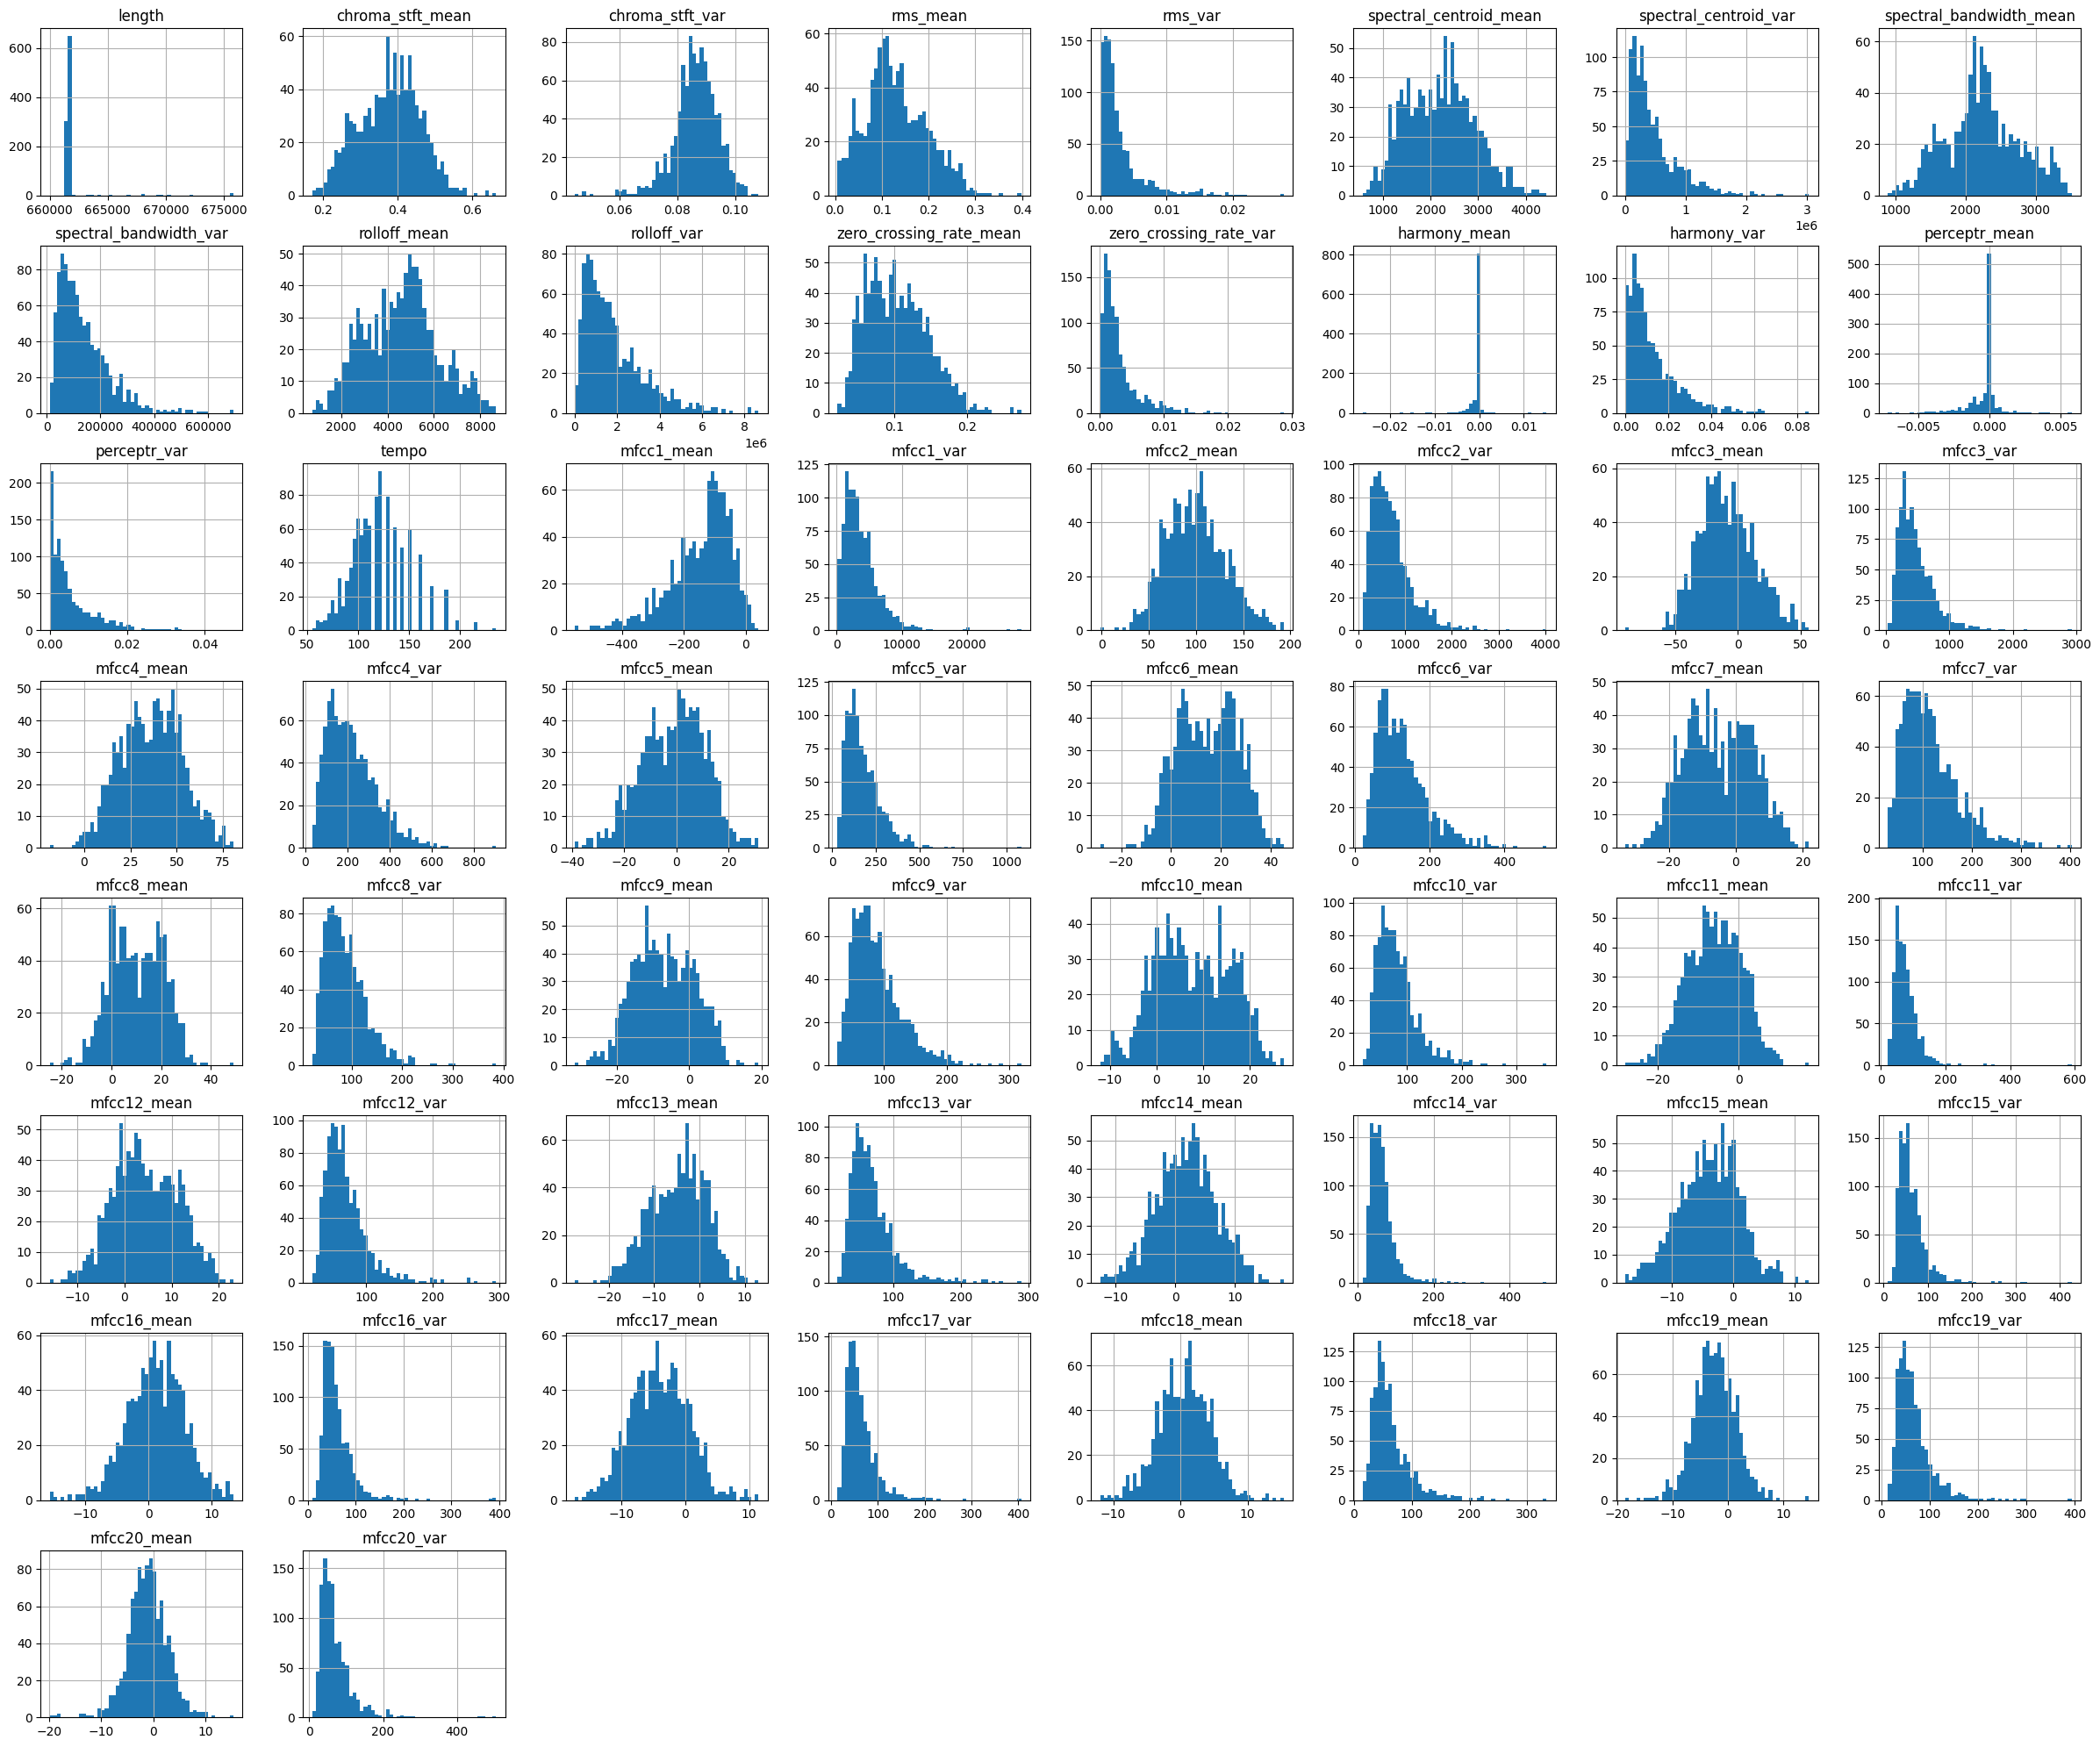

In [90]:
data.hist(bins=50, figsize=(30,25));

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [91]:
# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
data = train

# **Discover & Visualize the Data to Gain Insights**

### *Correlation Matrix Of Numerical Features* 
- This correlation matrix might look a bit tricky, but you can spot some patterns between audio features and MFCCs. In the upper left section, you’ll notice some moderate relationships between spectral and temporal audio features.

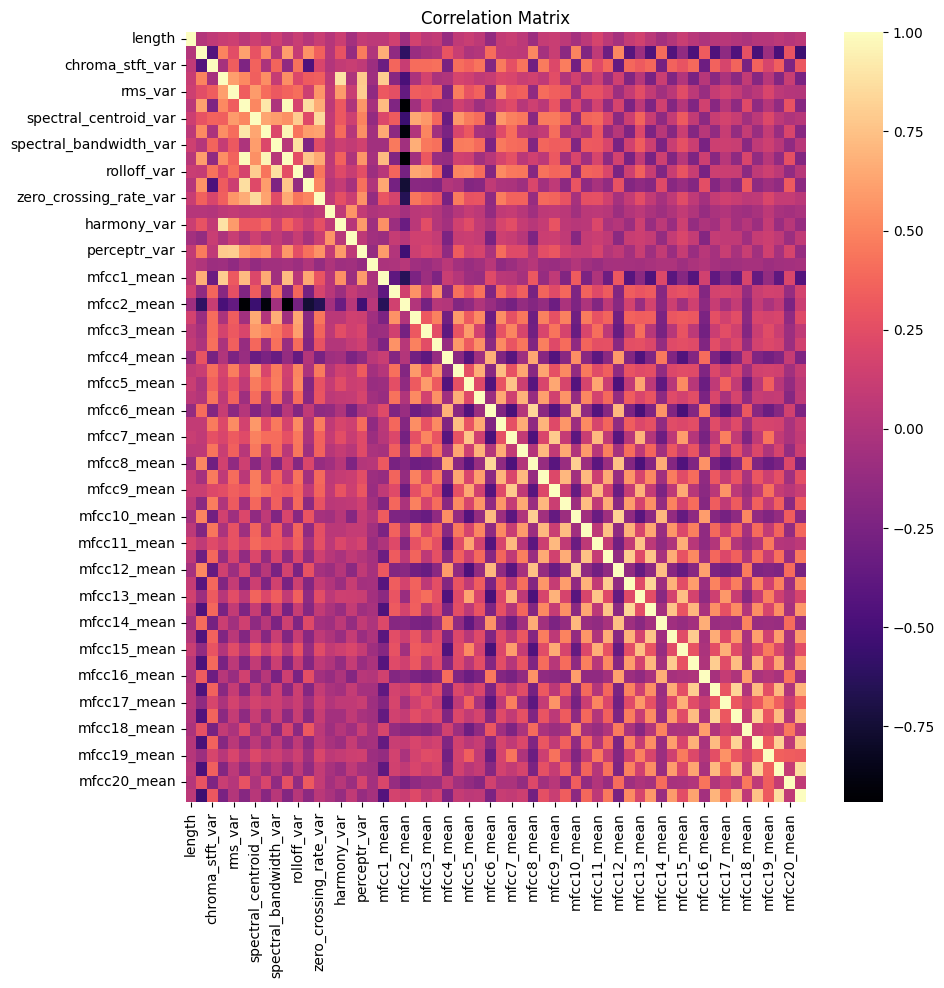

In [92]:
numeric_columns = data.select_dtypes(include=[np.number])

# Corelation matrix with sns
corr = numeric_columns.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='magma')
plt.title('Correlation Matrix')
plt.show()

### **RMS Feature Distributions Across Music Genres**

- The plot shows the distribution of the Root Mean Square (RMS) feature for different music genres, visualized using Kernel Density Estimation (KDE). It highlights how each genre's energy profile (loudness) varies, with genres like hip-hop and rock having distinct RMS characteristics compared to classical or jazz, which show more concentrated and narrower distributions.

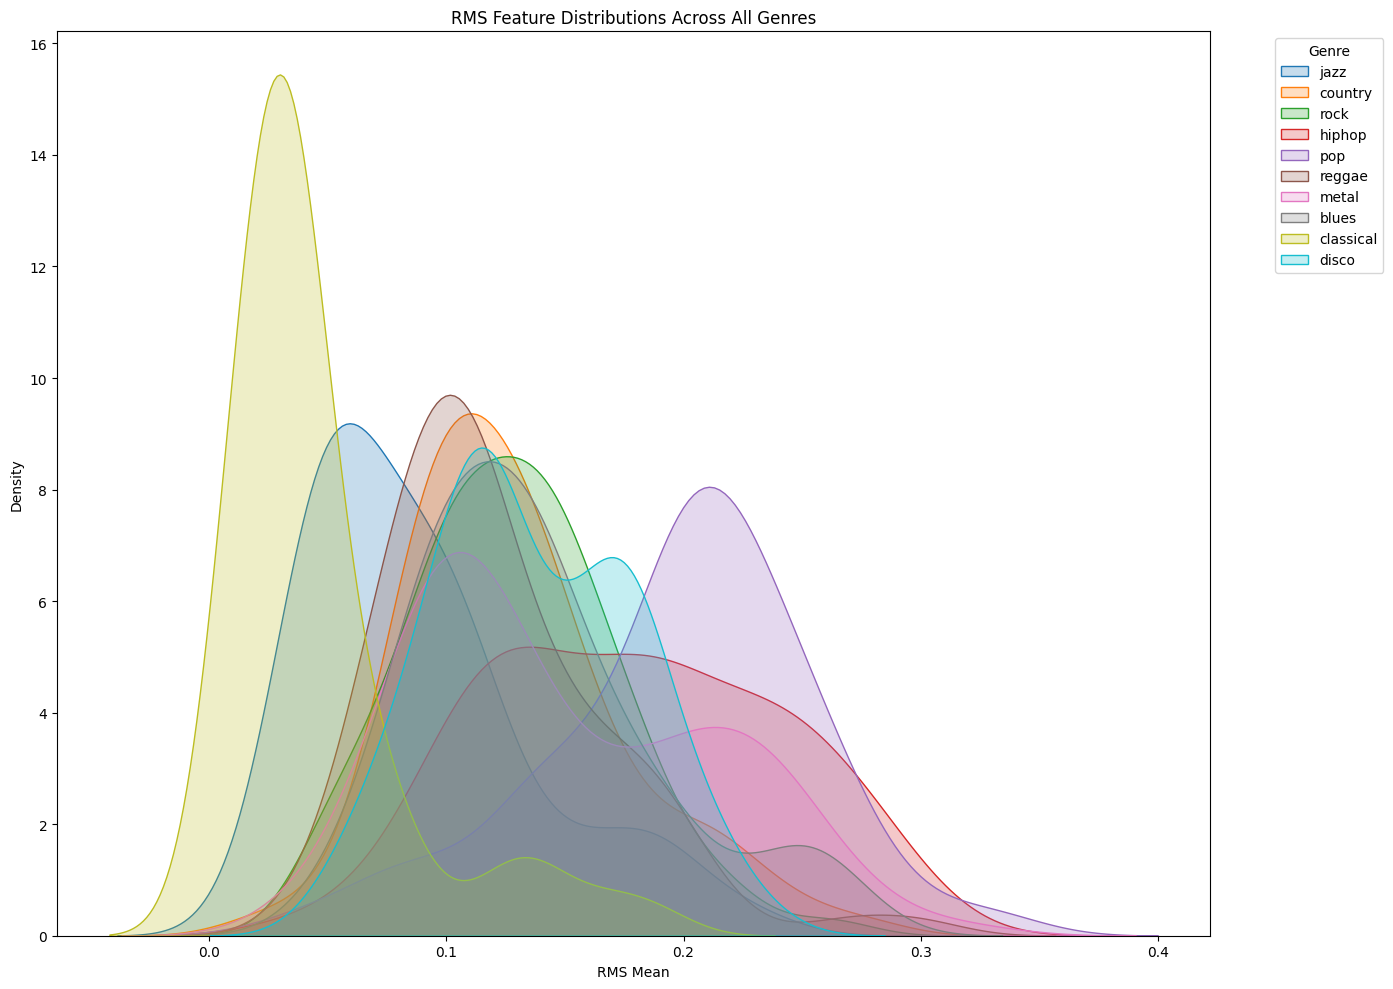

In [93]:
import warnings
plt.figure(figsize=(14, 10))

# Loop through all unique genres and plot their RMS feature distribution
warnings.filterwarnings('ignore')
for genre in data['label'].unique():
    sns.kdeplot(data=data[data['label'] == genre]['rms_mean'], label=genre, shade=True)

plt.title('RMS Feature Distributions Across All Genres')
plt.xlabel('RMS Mean')
plt.ylabel('Density')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

### *Spectral Centroid Across Genres*
- This chart compares the brightness or treble characteristics of different music genres using box plots, where higher values indicate brighter, more treble-heavy sounds, and lower values indicate darker, more bass-heavy sounds. Pop music shows the highest median brightness while classical and blues genres tend toward darker tones, and jazz displays the most variability in its tonal characteristics, ranging from very dark to very bright sounds.

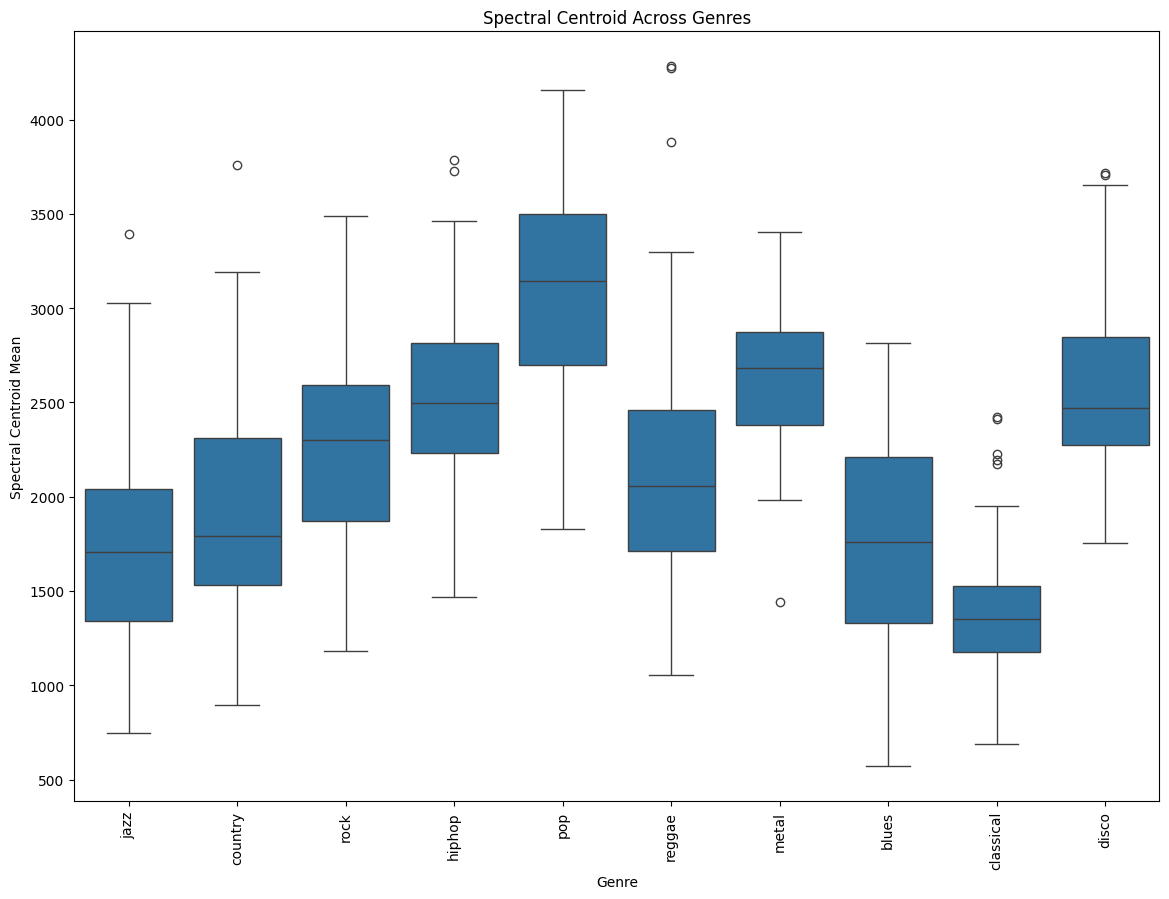

In [94]:
# Visualizing spectral_centroid across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='spectral_centroid_mean', data=data)
plt.title('Spectral Centroid Across Genres')
plt.xlabel('Genre')
plt.ylabel('Spectral Centroid Mean')
plt.xticks(rotation=90)
plt.show()



### *MFCC1 Mean Across Genres*

- This chart compares the first Mel-frequency cepstral coefficient (MFCC1) across different music genres, which reflects the overall energy distribution in the frequency spectrum. Classical music has the lowest median MFCC1 values and the most variability, indicating it has less consistent energy. Metal and pop, on the other hand, have higher median values, showing they have more consistent and energetic frequency content.

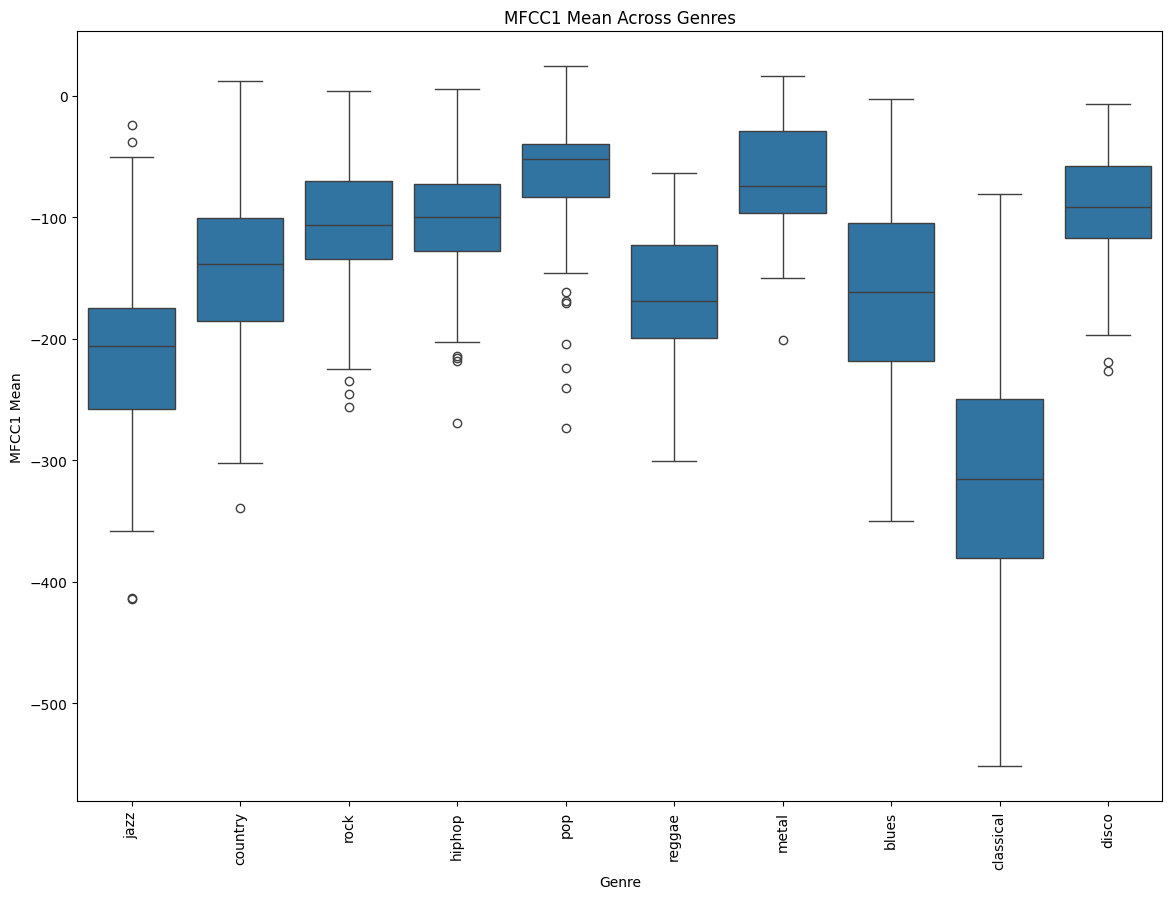

In [95]:
# Visualizing mfcc1_mean across genres
plt.figure(figsize=(14, 10))
sns.boxplot(x='label', y='mfcc1_mean', data=data)
plt.title('MFCC1 Mean Across Genres')
plt.xlabel('Genre')
plt.ylabel('MFCC1 Mean')
plt.xticks(rotation=90)
plt.show()

### *Using Librosa*

- **So we are going to use Librosa, which is a Python library for analyzing and processing audio signals, widely used in music information retrieval and machine learning applications.**

- This code uses **Librosa** to load an audio file, obtaining its time series (`y`) and sample rate (`sr`). It prints the shape of the audio array (`661504` samples), the sample rate (`22050 Hz`), and the audio length (`30 seconds`).










In [96]:
import librosa 
import librosa.display  
audio_path = "./audio/metal/metal.00094.wav"
# needs to be numpy 2.0 because librosa thinks its funny to break with numpy 1.21
%pip install numpy==2.0
# Load the audio file using librosa, y is the audio time series and sr is the sampling rate of y 
y, sr = librosa.load(audio_path)
y_shape = np.shape(y)  
print(f"y shape: {y_shape}, sample rate: {sr}, length: {y_shape[0] / sr} seconds")

You should consider upgrading via the '/Users/figueroaf/Desktop/Genre-Prediciton/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
y shape: (661504,), sample rate: 22050, length: 30.00018140589569 seconds


### Audio Waveform
- As you can see you can use librosa to create a visual representation of an audio waveform, or a audio signal as a waveplot, showing the changes in amplitude over time.



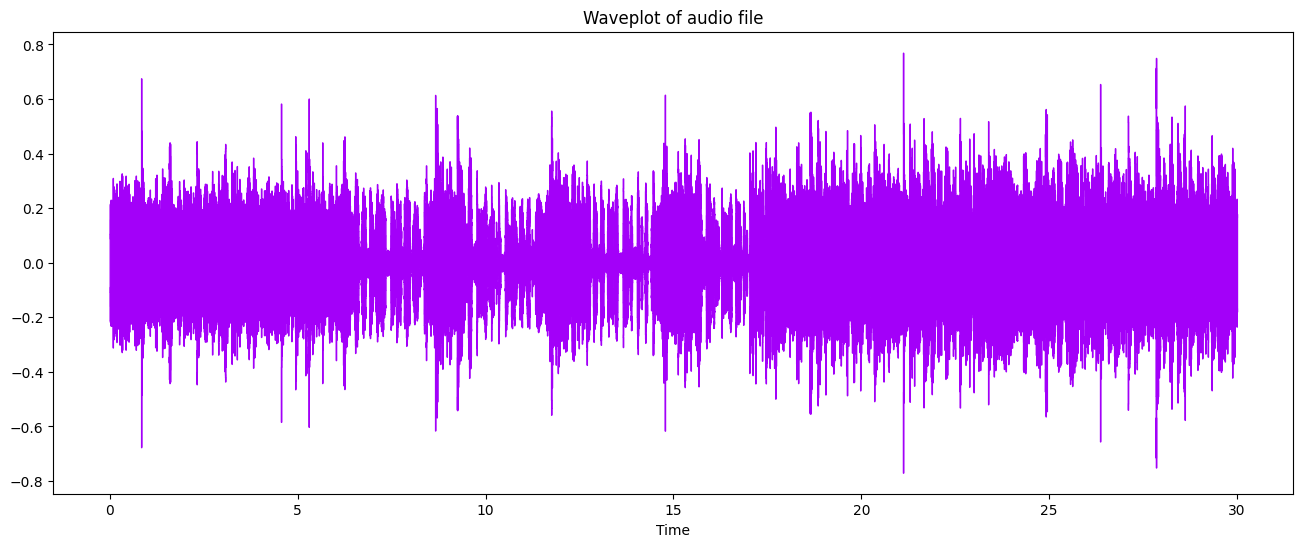

In [97]:
plt.figure(figsize=(16, 6)) 
librosa.display.waveshow(y, sr=sr, color="#A300F9") 
plt.title("Waveplot of audio file");

### *Audio STFT Spectogram*

- We can also use Librosa to create a spectrogram of an audio file, showing how its frequency content changes over time. It uses the Short-Time Fourier Transform (STFT) to convert the signal into a frequency domain and displays it in decibels on a logarithmic frequency scale.








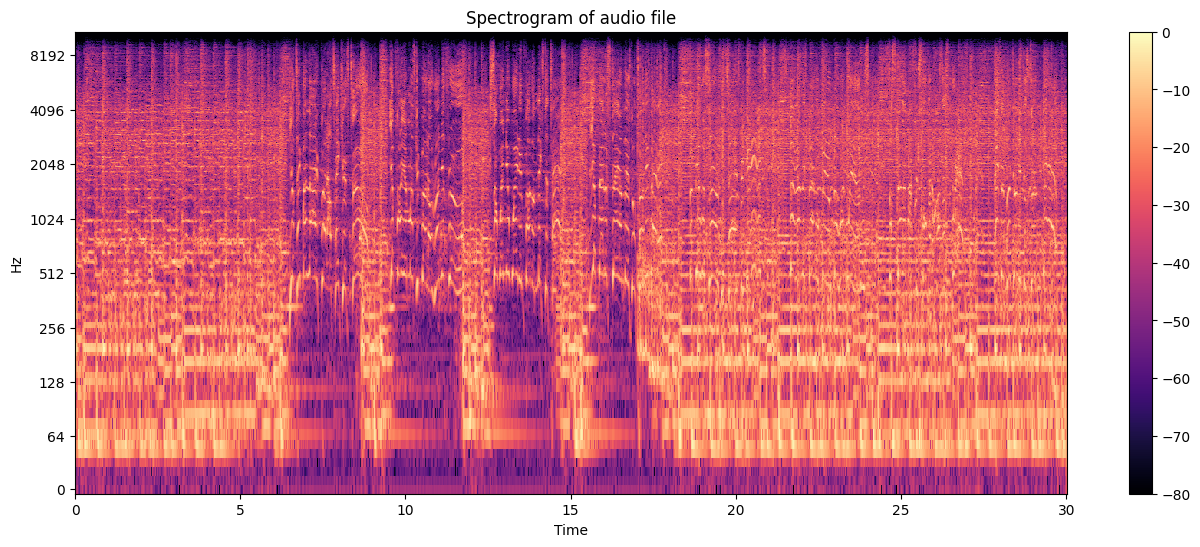

In [98]:
n_fft = 2048 
hop_length = 512  
audio_file, _ = librosa.effects.trim(y) 
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))  
DB = librosa.amplitude_to_db(D, ref = np.max)  
plt.figure(figsize = (16, 6)) 
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log') 
plt.colorbar();
plt.title("Spectrogram of audio file");
plt.show()

### *Average Energy (RMS) by Genre*

- This bar graph shows the average RMS (Root Mean Square) energy for different music genres. The pop genre has the highest energy, while classical has the lowest. By the way the  RMS (Root Mean Square) energy is basicaly the loudness of an audio signal by calculating the square root of the average of the squared values of the signal's waveform

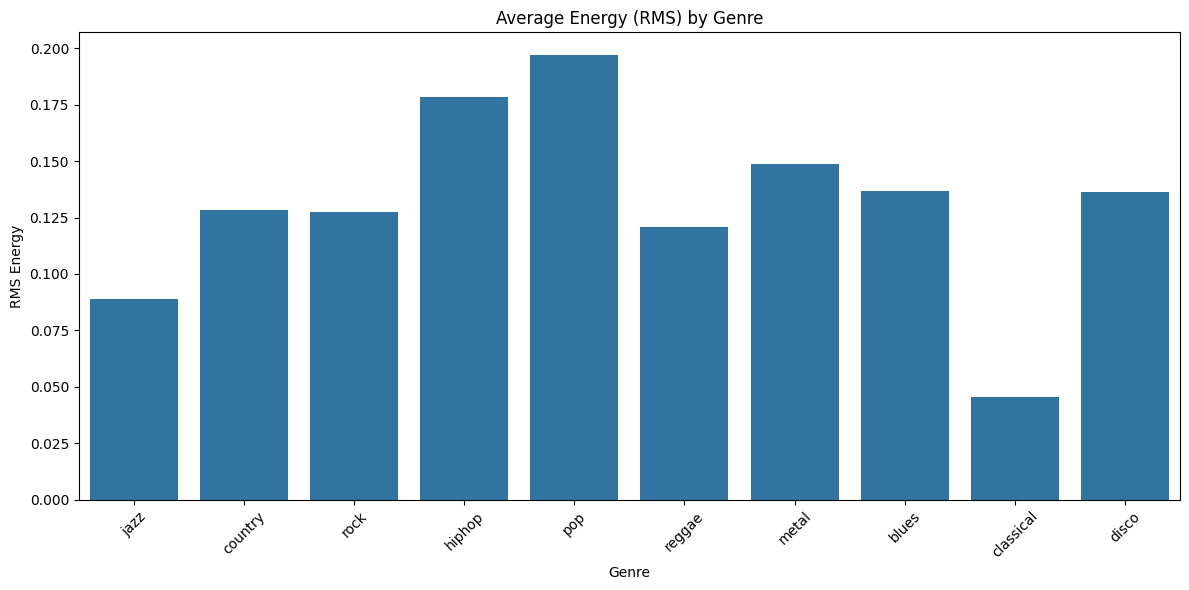

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='label', y='rms_mean', ci=None)
plt.title('Average Energy (RMS) by Genre')
plt.xlabel('Genre')
plt.ylabel('RMS Energy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Audio Mel Spectrogram

- This is similar to the other spectogram, its better for analyzing audio because it mimics how humans hear sound. It compresses the frequency axis to focus on the frequencies we are most sensitive to, making it more efficient for tasks like speech or music recognition (which is our case).

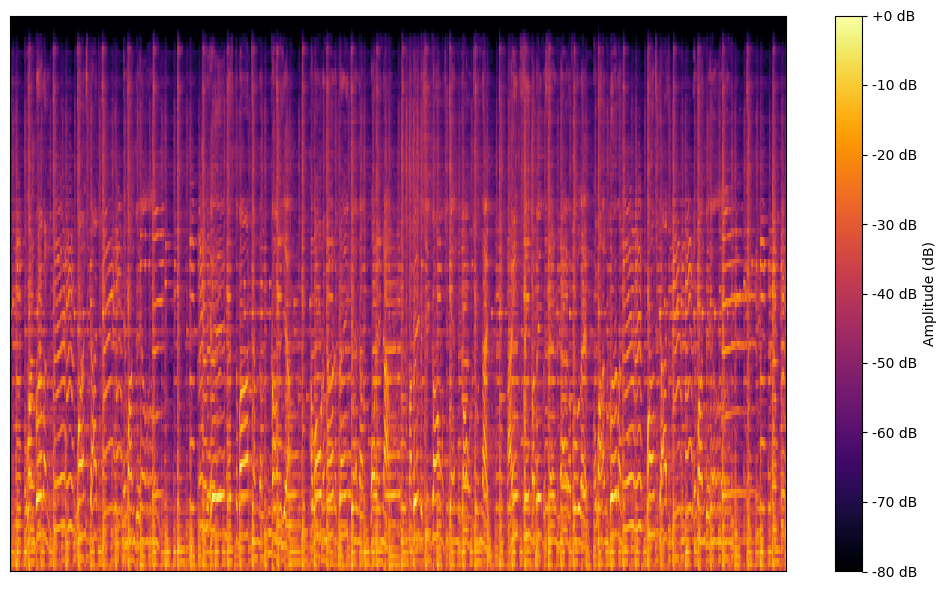

In [100]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

file = "./audio/blues/blues.00000.wav"  # Correct path
y, sr = librosa.load(file, sr=None)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spec_db, sr=sr, cmap='inferno')
plt.colorbar(format='%+2.0f dB', label="Amplitude (dB)")
plt.tight_layout()
plt.show()

# **Prepare The Data For Machine Learning Algorithms**
### *Model Imports*

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV


### *Predicting Label for X and Y*


In [102]:
# predict label give X and y val for both train and test

X = train.drop(columns=['label'])
y = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

### *Customer Transformers*

1. **ExtractMelSpectogram**: This class loads an audio file, detects its tempo, but doesn't return the Mel spectrogram yet (unfinished).

2. **LoadMelSpectograms**: This class loads audio files, computes their Mel spectrograms, and adds them as a new column in the dataset.

In [103]:
# Transformers
from sklearn.base import BaseEstimator, TransformerMixin

class ExtractMelSpectogram(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        split_file_path = X['filename'].split('.')
        audio_path = f"./audio/{split_file_path[0]}/{X['filename']}"
        y, sr = librosa.load(audio_path)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        return
    
class LoadMelSpectograms(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        mel_specs = [] 
        for i in range(X.shape[0]):
            split_file_path = X['filename'].iloc[i].split('.')
            audio_path = f"./audio/{split_file_path[0]}/{X['filename'].iloc[i]}"
            y, sr = librosa.load(audio_path)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_specs.append(mel_spec)
            X["mel_spec"] = mel_specs
        return X

### Audio Preprocessing Pipeline Explanation

This code creates a pipeline that prepares audio data for machine learning in 3 main steps:

1. **Audio Feature Extractor**
   - Simply removes the filename column 
   - Keeps all the numerical data about the audio features

2. **Additional Features Creator**
   - Creates new useful features by combining existing ones
   - For example: combines pitch and volume features to create new ratios
   - Also calculates average and variation of certain audio properties (MFCCs)

3. **Feature Scaler**
   - Groups similar features together (base features, MFCCs, variance features)
   - Scales each group separately to make sure all numbers are in a similar range
   - This helps the machine learning model perform better

Think of it like a recipe:
1. First, remove ingredients we don't need (filenames)
2. Then create new ingredients by mixing existing ones
3. Finally, measure everything in the same units so they work well together



In [104]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Custom transformer for handling audio features
class AudioFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = []
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Get all numerical columns except 'filename'
        self.feature_names = [col for col in X.columns if col != 'filename']
        return X[self.feature_names]

# Custom transformer for additional audio features
class AdditionalAudioFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        features = X.copy()
        
        # Calculate feature ratios
        features['spectral_rolloff_centroid_ratio'] = features['rolloff_mean'] / features['spectral_centroid_mean']
        features['bandwidth_centroid_ratio'] = features['spectral_bandwidth_mean'] / features['spectral_centroid_mean']
        features['rms_zcr_ratio'] = features['rms_mean'] / features['zero_crossing_rate_mean']
        
        # Calculate MFCC statistics
        mfcc_cols = [col for col in X.columns if 'mfcc' in col and 'mean' in col]
        features['mfcc_mean'] = features[mfcc_cols].mean(axis=1)
        features['mfcc_std'] = features[mfcc_cols].std(axis=1)
        
        return features

# Define column groups
def get_feature_groups(X):
    base_features = ['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 
                    'spectral_bandwidth_mean', 'rolloff_mean', 'zero_crossing_rate_mean']
    
    mfcc_features = [col for col in X.columns if 'mfcc' in col]
    variance_features = [col for col in X.columns if 'var' in col]
    
    return base_features, mfcc_features, variance_features

# Create the preprocessing pipeline
def create_preprocessing_pipeline(X):
    base_features, mfcc_features, variance_features = get_feature_groups(X)
    
    # Create feature-specific scalers
    feature_scalers = ColumnTransformer([
        ('base_scaler', StandardScaler(), base_features),
        ('mfcc_scaler', StandardScaler(), mfcc_features),
        ('variance_scaler', StandardScaler(), variance_features)
    ])
    
    # Build the full preprocessing pipeline
    preprocessor = Pipeline([
        ('feature_extractor', AudioFeatureExtractor()),
        ('additional_features', AdditionalAudioFeatures()),
        ('feature_scaling', feature_scalers)
    ])
    
    return preprocessor

# Create and return the preprocessor
preprocessor = create_preprocessing_pipeline(X)
preprocessor

Pipeline(steps=[('feature_extractor', AudioFeatureExtractor()),
                ('additional_features', AdditionalAudioFeatures()),
                ('feature_scaling',
                 ColumnTransformer(transformers=[('base_scaler',
                                                  StandardScaler(),
                                                  ['chroma_stft_mean',
                                                   'rms_mean',
                                                   'spectral_centroid_mean',
                                                   'spectral_bandwidth_mean',
                                                   'rolloff_mean',
                                                   'zero_crossing_rate_mean']),
                                                 ('mfcc_scaler',
                                                  StandardScaler(...
                                                   'spectral_bandwidth_var',
                                                   'rolloff_var',
                                                   'zero_crossing_rate_var',
                                                   'harmony_var',
                                                   'perceptr_var', 'mfcc1_var',
                                                   'mfcc2_var', 'mfcc3_var',
                                                   'mfcc4_var', 'mfcc5_var',
                                                   'mfcc6_var', 'mfcc7_var',
                                                   'mfcc8_var', 'mfcc9_var',
                                                   'mfcc10_var', 'mfcc11_var',
                                                   'mfcc12_var', 'mfcc13_var',
                                                   'mfcc14_var', 'mfcc15_var',
                                                   'mfcc16_var', 'mfcc17_var',
                                                   'mfcc18_var', 'mfcc19_var',
                                                   'mfcc20_var'])]))])

### *Fitting X*

In [105]:
X_preprocessed = preprocessor.fit_transform(X)

In [106]:
X_preprocessed.shape, y.shape

((800, 74), (800,))

Table based on the Mean Cross-validation Scores:

| Classifier             | Mean CV Score | Accuracy | Precision | Recall | F1 Score |
|------------------------|---------------|----------|-----------|--------|----------|
| **Logistic Regression**| 0.6988        | 0.87     | 0.8698    | 0.87   | 0.8685   |
| **SVC**                | 0.6975        | 0.865    | 0.8697    | 0.865  | 0.8655   |
| **Gradient Boosting**  | 0.6588        | 0.9988   | 0.9988    | 0.9988 | 0.9987   |
| **KNN Classifier**     | 0.6575        | 0.805    | 0.8102    | 0.805  | 0.8045   |
| **Random Forest**      | 0.6638        | 0.9988   | 0.9988    | 0.9988 | 0.9987   |
| **Ridge Classifier**   | 0.6350        | 0.7388   | 0.7503    | 0.7388 | 0.7280   |
| **SGD Classifier**     | 0.6188        | 0.7863   | 0.7950    | 0.7863 | 0.7875   |
| **Bagging Classifier** | 0.6063        | 0.7775   | 0.7886    | 0.7775 | 0.7777   |
| **Decision Tree**      | 0.4200        | 0.5375   | 0.6090    | 0.5375 | 0.5288   |
| **AdaBoost**           | 0.2688        | 0.2963   | 0.2580    | 0.2963 | 0.2264   |

### Notes:
- **Gradient Boosting** and **Random Forest** both show extremely high accuracy, which might indicate overfitting, especially since their F1 Scores are similarly high.
- **Logistic Regression** and **SVC** remain strong performers with balanced metrics and reliable results.
- **AdaBoost** has the worst performance with a very low mean cross-validation score, accuracy, and F1 Score.

In [107]:
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import numpy as np


# List of models for direct scoring (those that don't require cross-validation)
models = [
    ("SGD Classifier", SGDClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Ridge Classifier", RidgeClassifier(alpha=1.0)),
    ("KNN Classifier", KNeighborsClassifier(n_neighbors=5)),
    ("SVC", SVC(kernel="rbf", C=1, gamma="scale", random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=5))
]

# Loop through the models and calculate direct scores as well as cross-validation scores
for name, model in models:
    # Cross-validation scores
    cross_val_scores = cross_val_score(model, X_preprocessed, y, cv=5)
    print(f"{name} Cross-validation scores: {cross_val_scores}")
    print(f"{name} Mean cross-validation score: {cross_val_scores.mean()}")

    # Fit the model for direct scoring and metric calculation
    model.fit(X_preprocessed, y)
    y_pred = model.predict(X_preprocessed)  # Predictions for scoring metrics

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')
    recall = recall_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')
    f1 = f1_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print("-" * 50)

# Additional ensemble models for comparison
ensemble_models = [
    ("Voting Classifier", VotingClassifier(estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(kernel="rbf", C=1, gamma="scale", random_state=42))
    ], voting='hard')),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=100, random_state=42)),
]

for name, model in ensemble_models:
    cross_val_scores = cross_val_score(model, X_preprocessed, y, cv=5)
    print(f"{name} Cross-validation scores: {cross_val_scores}")
    print(f"{name} Mean cross-validation score: {cross_val_scores.mean()}")
    print("-" * 50)


SGD Classifier Cross-validation scores: [0.625   0.55    0.68125 0.70625 0.53125]
SGD Classifier Mean cross-validation score: 0.61875
SGD Classifier Accuracy: 0.78625
SGD Classifier Precision: 0.7949918096672913
SGD Classifier Recall: 0.78625
SGD Classifier F1 Score: 0.7875375210819064
--------------------------------------------------
Logistic Regression Cross-validation scores: [0.69375 0.675   0.70625 0.74375 0.675  ]
Logistic Regression Mean cross-validation score: 0.6987500000000001
Logistic Regression Accuracy: 0.87
Logistic Regression Precision: 0.8698451296783007
Logistic Regression Recall: 0.87
Logistic Regression F1 Score: 0.8684504183178327
--------------------------------------------------
Ridge Classifier Cross-validation scores: [0.65    0.61875 0.6625  0.65625 0.5875 ]
Ridge Classifier Mean cross-validation score: 0.635
Ridge Classifier Accuracy: 0.73875
Ridge Classifier Precision: 0.7503461658233413
Ridge Classifier Recall: 0.73875
Ridge Classifier F1 Score: 0.727988710

### *Pipeline for Extracting and Processing Mel Spectrogram Features from Existing and Generated Audio*


The code provides two pipelines for processing audio data: 

1. **ExistingSpectrogramProcessor**: This pipeline can be used when you already have a dataset with extracted features, such as MFCCs and spectral features, and you want to filter and standardize these features for machine learning tasks like genre classification. For example, you can input a dataset with columns like `mfcc_1_mean`, `spectral_centroid_mean`, and it will output these cleaned and standardized features ready for model training.

2. **GeneratedSpectrogramProcessor**: This pipeline is used to generate features from raw audio files, such as calculating mel spectrograms, MFCCs, and spectral centroids from songs. For example, given a folder of `.wav` files, this pipeline will process each file to extract features like `mel_mean`, `mfcc_1_mean`, and `spec_centroid_mean`, which can be used in machine learning models for tasks like genre classification or music recommendation.




In [108]:
import numpy as np
import librosa
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

class ExistingSpectrogramProcessor(BaseEstimator, TransformerMixin):
    """Process existing mel spectrograms from the dataset"""
    def __init__(self):
        self.feature_names = []
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Filter out the corrupted file if present
        X = X[X['filename'] != 'jazz.00054.wav'].copy()
        
        # Extract only the mel spectrogram related features from existing data
        mel_features = [col for col in X.columns if 'mfcc' in col]
        spectral_features = [col for col in X.columns if 'spectral' in col]
        self.feature_names = mel_features + spectral_features
        
        return X[self.feature_names]

class GeneratedSpectrogramProcessor(BaseEstimator, TransformerMixin):
    """Generate and process new mel spectrograms from audio files"""
    def __init__(self, n_mels=128, hop_length=512, n_mfcc=20):
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.feature_template = None
        
    def fit(self, X, y=None):
        return self
        
    def _process_audio_file(self, audio_path):
        """Process a single audio file and extract features"""
        y, sr = librosa.load(audio_path, sr=None)
        
        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=y, 
            sr=sr, 
            n_mels=self.n_mels,
            hop_length=self.hop_length
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        features = {}
        
        # Calculate statistical features
        features['mel_mean'] = np.mean(mel_spec_db)
        features['mel_std'] = np.std(mel_spec_db)
        features['mel_max'] = np.max(mel_spec_db)
        features['mel_min'] = np.min(mel_spec_db)
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        for i, mfcc in enumerate(mfccs):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfcc)
            features[f'mfcc_{i+1}_std'] = np.std(mfcc)
        
        # Calculate spectral features
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spec_centroid_mean'] = np.mean(spectral_centroid)
        features['spec_centroid_std'] = np.std(spectral_centroid)
        
        return features
        
    def transform(self, X):
        # Filter out the corrupted file
        X = X[X['filename'] != 'jazz.00054.wav'].copy()
        
        features_list = []
        valid_indices = []
        
        for idx, filename in enumerate(X['filename']):
            try:
                audio_path = f"./audio/{filename.split('.')[0]}/{filename}"
                if os.path.exists(audio_path):
                    features = self._process_audio_file(audio_path)
                    features_list.append(features)
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping {filename}: {str(e)}")
                continue
        
        if not features_list:
            raise ValueError("No valid audio files were processed")
        
        # Convert to numpy array
        feature_matrix = np.array([[v for v in d.values()] for d in features_list])
        
        return feature_matrix

def create_existing_spectrogram_pipeline():
    """Create pipeline for processing existing spectrograms"""
    return Pipeline([
        ('processor', ExistingSpectrogramProcessor()),
        ('scaler', StandardScaler())
    ])

def create_generated_spectrogram_pipeline():
    """Create pipeline for generating and processing new spectrograms"""
    return Pipeline([
        ('processor', GeneratedSpectrogramProcessor()),
        ('scaler', StandardScaler())
    ])

def process_data(X, y=None, pipeline_type='existing'):
    """
    Process data using specified pipeline type
    
    Args:
        X: Input data DataFrame
        y: Labels (optional)
        pipeline_type: 'existing' or 'generated'
    
    Returns:
        Processed features and filtered labels (if provided)
    """
    # Create a copy of the data to avoid modifying the original
    X = X.copy()
    
    # Remove the corrupted file from both X and y
    mask = X['filename'] != 'jazz.00054.wav'
    X = X[mask]
    
    if y is not None:
        y = y[mask]
    
    if pipeline_type == 'existing':
        pipeline = create_existing_spectrogram_pipeline()
    else:
        pipeline = create_generated_spectrogram_pipeline()
    
    X_processed = pipeline.fit_transform(X)
    
    if y is not None:
        return X_processed, y
    return X_processed

### *Handling Audio Data with and without Labels Using Mel Spectrogram Processing Pipelines*

In [109]:
# If you don't have labels:
X_existing = process_data(data, pipeline_type='existing')
X_generated = process_data(data, pipeline_type='generated')

# If you have labels:
X_existing, y_filtered = process_data(data, y, pipeline_type='existing')
X_generated, y_filtered = process_data(data, y, pipeline_type='generated')

### *Accuracy For Model With Generated Vs Existing Data*

In [110]:
def simple_compare_models(X_existing, X_generated, y_filtered):
    # Define models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42)
    }
    
    # Store results
    results = {}
    
    for name, model in models.items():
        # Test existing features
        model.fit(X_existing, y_filtered)
        existing_score = model.score(X_existing, y_filtered) * 100
        
        # Test generated features
        model.fit(X_generated, y_filtered)
        generated_score = model.score(X_generated, y_filtered) * 100
        
        results[name] = {
            'Existing': f"{existing_score:.1f}%",
            'Generated': f"{generated_score:.1f}%"
        }
    
    # Print results in a simple format
    print("\nAccuracy Comparison:")
    print("-" * 50)
    print(f"{'Model':<20} {'Existing':<15} {'Generated':<15}")
    print("-" * 50)
    for model, scores in results.items():
        print(f"{model:<20} {scores['Existing']:<15} {scores['Generated']:<15}")

# Run comparison
simple_compare_models(X_existing, X_generated, y_filtered)


Accuracy Comparison:
--------------------------------------------------
Model                Existing        Generated      
--------------------------------------------------
Random Forest        99.9%           99.9%          
Gradient Boosting    99.9%           99.9%          
SVM                  84.5%           86.0%          


### Confusion Matrices For Generated Vs Extracted Data

- Looking at these confusion matrices, `Random Forest` and `Gradient Boosting` models perform exceptionally well with both existing and generated features, consistently achieving around 80 correct predictions for each class (shown by the dark diagonal values) with almost no misclassifications. In contrast, the `SVM` model performs notably worse, with more misclassifications (shown by the off-diagonal numbers) and lower accuracy scores around 60-70 for each class.

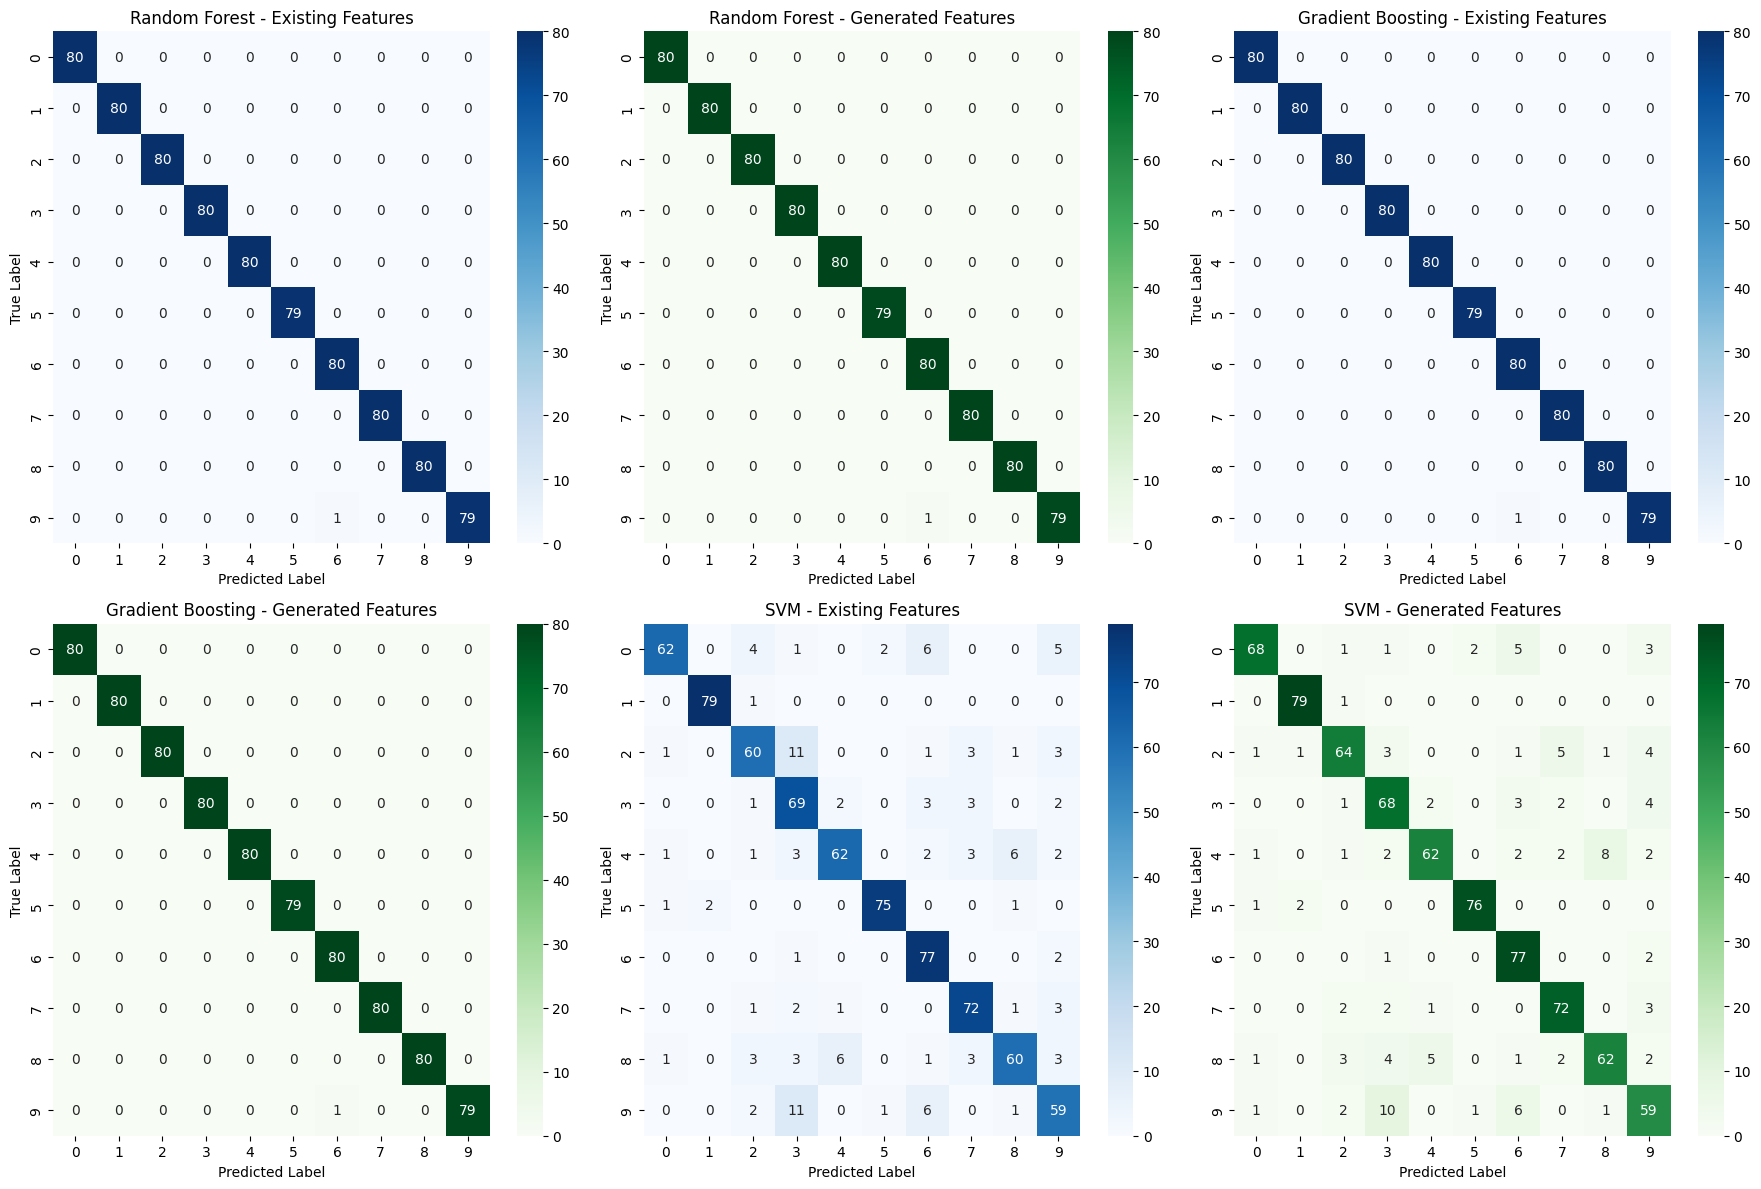

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrices(X_existing, X_generated, y_filtered):
    # Define models to test
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42)
    }
    
    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()  # Flatten for easier indexing
    
    for i, (name, model) in enumerate(models.items()):
        # Train and evaluate on existing features
        model.fit(X_existing, y_filtered)
        existing_pred = model.predict(X_existing)
        existing_cm = confusion_matrix(y_filtered, existing_pred)
        
        # Train and evaluate on generated features
        model.fit(X_generated, y_filtered)
        generated_pred = model.predict(X_generated)
        generated_cm = confusion_matrix(y_filtered, generated_pred)
        
        # Plot confusion matrix for existing features
        sns.heatmap(existing_cm, annot=True, fmt='d', cmap='Blues', ax=axes[i * 2])
        axes[i * 2].set_title(f'{name} - Existing Features')
        axes[i * 2].set_ylabel('True Label')
        axes[i * 2].set_xlabel('Predicted Label')
        
        # Plot confusion matrix for generated features
        sns.heatmap(generated_cm, annot=True, fmt='d', cmap='Greens', ax=axes[i * 2 + 1])
        axes[i * 2 + 1].set_title(f'{name} - Generated Features')
        axes[i * 2 + 1].set_ylabel('True Label')
        axes[i * 2 + 1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(X_existing, X_generated, y_filtered)

### *Existing Vs Generate Spectogram*

- Alright, so here's what we're looking at: on the left, we've got the **generated spectrogram**, and on the right are the **existing MFCC features**. The spectrogram shows way more detail over time, while the MFCCs are more simplified and smoothed out. Even though they’re **81.3% similar**, the spectrogram captures richer information, which means using it might give us better results than sticking with the existing features.

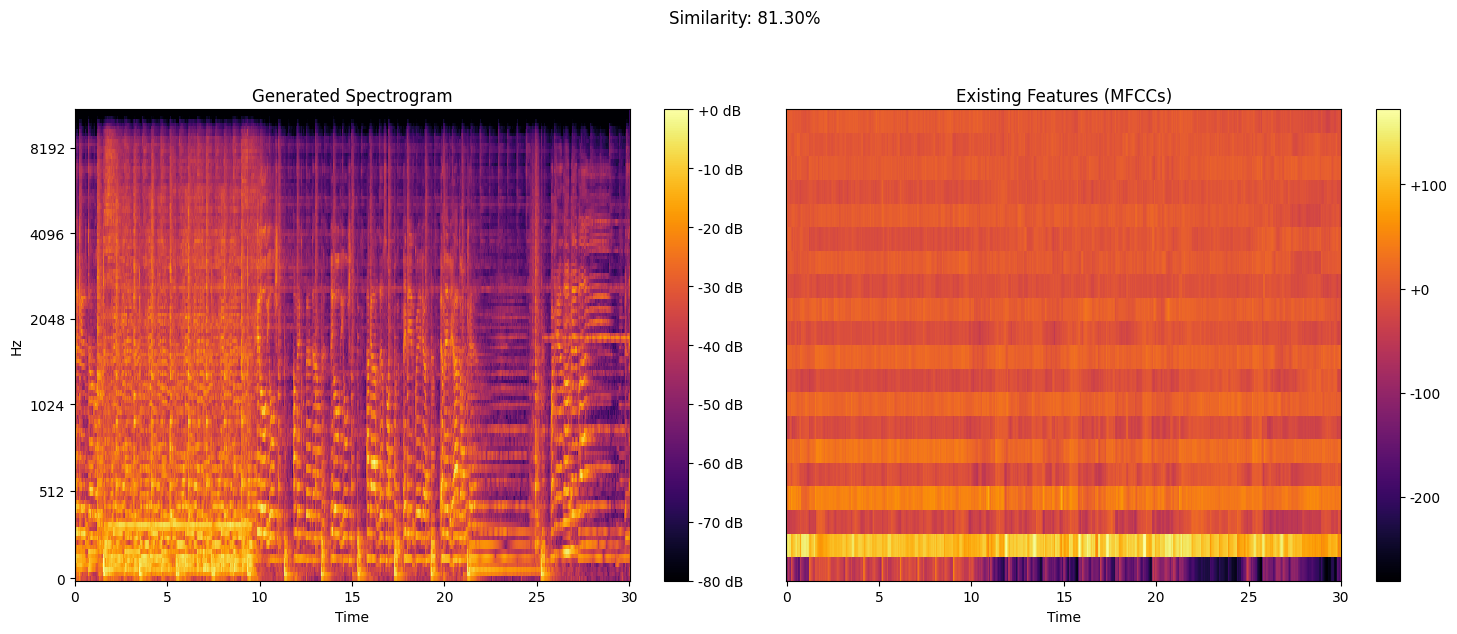

Similarity percentage: 81.30%


In [112]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

def compare_spectrograms_with_similarity(audio_path):
    plt.figure(figsize=(15, 6))
    
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # 1. Generated Spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=128,
        hop_length=512
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    plt.subplot(1, 2, 1)
    librosa.display.specshow(
        mel_spec_db, 
        sr=sr, 
        x_axis='time', 
        y_axis='mel',
        cmap='inferno'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title('Generated Spectrogram')
    
    # 2. Existing Features (MFCCs)
    plt.subplot(1, 2, 2)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    librosa.display.specshow(
        mfccs, 
        sr=sr, 
        x_axis='time',
        cmap='inferno'
    )
    plt.colorbar(format='%+2.0f')
    plt.title('Existing Features (MFCCs)')
    
    # Calculate similarity
    mel_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    mfcc_norm = (mfccs - mfccs.min()) / (mfccs.max() - mfccs.min())
    
    # Calculate zoom factors
    zoom_factors = (mel_norm.shape[0] / mfcc_norm.shape[0], 
                   mel_norm.shape[1] / mfcc_norm.shape[1])
    
    # Resize MFCC to match mel spectrogram size
    mfcc_resized = zoom(mfcc_norm, zoom_factors)
    
    # Calculate similarity (as percentage)
    similarity = 100 * (1 - np.mean(np.abs(mel_norm - mfcc_resized)))
    
    plt.suptitle(f'Similarity: {similarity:.2f}%', y=1.05)
    plt.tight_layout()
    plt.show()
    
    return similarity

# Example usage
audio_path = "./audio/rock/rock.00000.wav"  # Replace with your audio file
similarity = compare_spectrograms_with_similarity(audio_path)
print(f"Similarity percentage: {similarity:.2f}%")

# **Fine Tuning Your Model**

### *Logistic Regression Model Fine Tuned*

| **Metric**                | **Value**  |
|---------------------------|------------|
| **Best Hyperparameters**   | C: 1, Penalty: 'l1', Solver: 'saga' |
| **Cross-Validation Score** | 0.7112     |
| **Accuracy**               | 0.8638     |
| **Precision**              | 0.8635     |
| **Recall**                 | 0.8638     |
| **F1 Score**               | 0.8628     |



In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define parameter grid for Logistic Regression
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],       # Regularization type
        'solver': ['liblinear', 'saga']  # Solvers supporting l1/l2 penalties
    }
}

# Model definition
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

# Perform grid search for Logistic Regression
for name, model in models.items():
    print(f"\nGrid Search for {name}...")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_preprocessed, y)
    
    # Print the best parameters and cross-validation score
    print(f"\nBest parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_:.4f}")
    
    # Use the best model to predict and evaluate on the training set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_preprocessed)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')  # Change if binary/multiclass
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    
    # Print metrics
    print(f"\n{name} Training Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 50)



Grid Search for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] EN

/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.8s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l1, solver=saga; total time=   2.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   1.9s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   2.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   2.2s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   1.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   1.9s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   1.9s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   2.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.1s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   2.3s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   2.2s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=   2.2s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.1s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.0s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   2.2s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   1.1s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=   2.3s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=   2.8s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   2.8s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=   2.7s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.2s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=   2.6s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   1.2s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=   2.8s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   7.2s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   1.4s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   1.5s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time=   1.4s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   7.8s


/Users/figueroaf/Desktop/Genre-Prediciton/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l2, solver=saga; total time=   1.0s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=  11.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=  11.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=  12.0s

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score for Logistic Regression: 0.7112

Logistic Regression Training Metrics:
Accuracy: 0.8638
Precision: 0.8635
Recall: 0.8638
F1 Score: 0.8628
--------------------------------------------------


# **Evaluating The Model**

### *Multiclass Model Evaluation with ROC AUC*

- The confusion matrix shows strong diagonal values (ranging from 10-19) indicating good classification performance across all 10 classes, with Class 1 having the highest accuracy (19 correct predictions) and Class 9 having the lowest (10 correct predictions). The ROC curves demonstrate exceptional model performance with very high AUC scores for all classes, particularly Class 1 achieving a perfect AUC of 1.00, while Class 3 has the lowest but still strong AUC of 0.86. The most common misclassifications appear to be between Class 9 and Class 2 (6 instances) and between Class 4 and Class 8 (6 instances), suggesting some overlapping features between these particular music genres.

| Genre | Precision | Recall | F1-Score | Support |
|---------|-----------|---------|-----------|----------|
| Blues | 0.67 | 0.60 | 0.63 | 20 |
| Classical | 0.95 | 0.95 | 0.95 | 20 |
| Country | 0.62 | 0.65 | 0.63 | 20 |
| Disco | 0.83 | 0.50 | 0.62 | 20 |
| Hip Hop | 0.52 | 0.55 | 0.54 | 20 |
| Jazz | 0.71 | 0.85 | 0.77 | 20 |
| Metal | 0.89 | 0.80 | 0.84 | 20 |
| Pop | 0.81 | 0.85 | 0.83 | 20 |
| Reggae | 0.54 | 0.70 | 0.61 | 20 |
| Rock | 0.53 | 0.50 | 0.51 | 20 |
| **Accuracy** | - | - | 0.69 | 200 |
| **Macro Avg** | 0.71 | 0.70 | 0.69 | 200 |
| **Weighted Avg** | 0.71 | 0.69 | 0.69 | 200 |


- Classical music has the best performance with 0.95 across precision, recall, and F1-score
- Rock has the lowest F1-score at 0.51, followed by Hip Hop at 0.54
- The overall model accuracy is 0.69, or 69%
- Metal and Pop also perform well with F1-scores above 0.80

Classification Report:
              precision    recall  f1-score   support

       blues       0.67      0.60      0.63        20
   classical       0.95      0.95      0.95        20
     country       0.62      0.65      0.63        20
       disco       0.83      0.50      0.62        20
      hiphop       0.52      0.55      0.54        20
        jazz       0.71      0.85      0.77        20
       metal       0.89      0.80      0.84        20
         pop       0.81      0.85      0.83        20
      reggae       0.54      0.70      0.61        20
        rock       0.53      0.50      0.51        20

    accuracy                           0.69       200
   macro avg       0.71      0.70      0.69       200
weighted avg       0.71      0.69      0.69       200



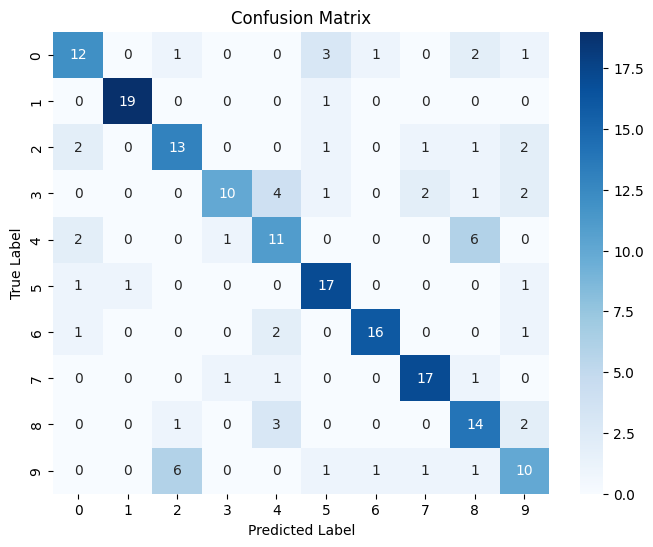

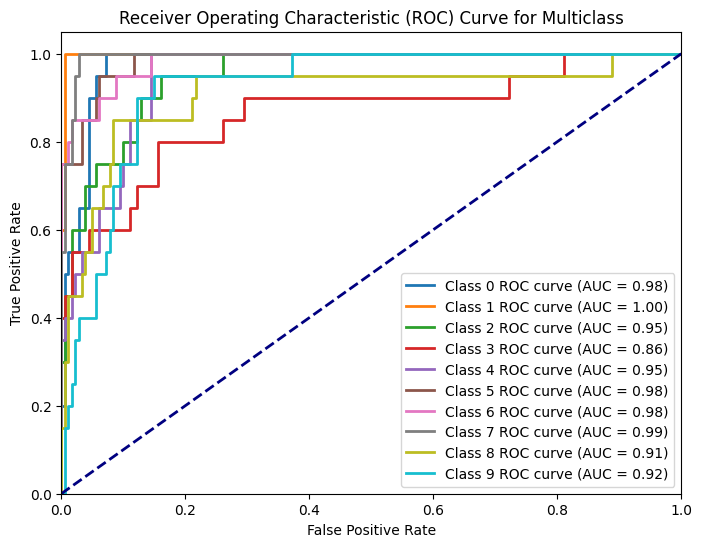

In [118]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, label_binarize



def evaluate_model(model, X_test, y_test, preprocessor):
    # Ensure that the preprocessor handles unknown categories
    if isinstance(preprocessor, OneHotEncoder):
        preprocessor = OneHotEncoder(handle_unknown='ignore')
        preprocessor.fit(X_test)  # Fit the encoder on the test data (or combine train and test data)
    
    # Preprocess test data
    X_test_processed = preprocessor.transform(X_test)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)  # For multiclass, this returns probabilities for all classes
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # For multiclass ROC, we need to binarize the labels
    y_test_binarized = label_binarize(y_test, classes=model.classes_)
    
    # Compute ROC AUC for each class
    roc_auc = {}
    for i in range(y_test_binarized.shape[1]):
        roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(y_test_binarized.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

# Example usage:
X_test_set = test.drop(columns=['label'])
y_test_set = test['label']
results = evaluate_model(best_model, X_test_set, y_test_set, preprocessor)


### *Predictions vs Actual Bar Plot*

- The overall model accuracy is 69.5%, with classical music achieving the highest genre-specific accuracy at 95% while disco and rock were the most challenging at 50% correct predictions. Jazz, metal, and pop showed strong performance with 80-85% accuracy rates, contributing significantly to the model's overall performance across all genres.

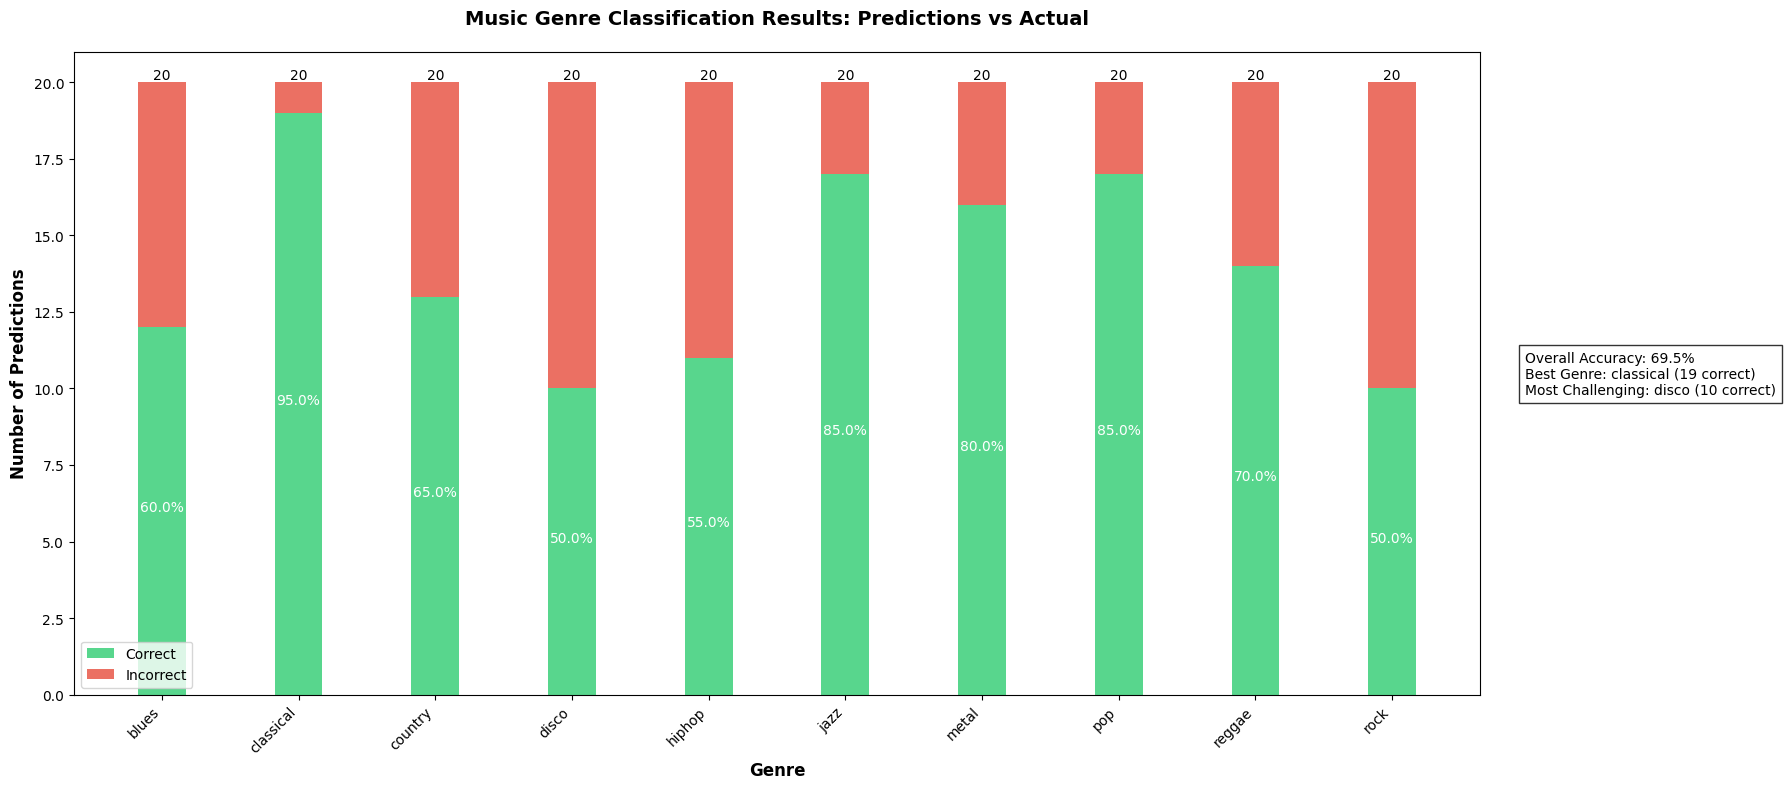

In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_test_predictions_plot(y_test, y_pred, genres):
    """
    Create a visualization comparing test predictions with actual labels.
    
    Parameters:
    -----------
    y_test : array-like
        True labels
    y_pred : array-like
        Predicted labels
    genres : list
        List of genre names
    """
    # Calculate correct and incorrect predictions per genre
    results = []
    for genre in genres:
        # Get indices for this genre
        genre_indices = y_test == genre
        total = np.sum(genre_indices)
        correct = np.sum((y_test == y_pred) & genre_indices)
        incorrect = total - correct
        results.append({'genre': genre, 'correct': correct, 'incorrect': incorrect})

    # Create figure and axis
    plt.figure(figsize=(15, 8))
    
    # Create positions for bars
    genres = [r['genre'] for r in results]
    correct = [r['correct'] for r in results]
    incorrect = [r['incorrect'] for r in results]
    
    # Set width of bars and positions of the bars
    bar_width = 0.35
    x = np.arange(len(genres))
    
    # Create bars
    plt.bar(x, correct, bar_width, label='Correct', color='#2ecc71', alpha=0.8)
    plt.bar(x, incorrect, bar_width, bottom=correct, label='Incorrect', color='#e74c3c', alpha=0.8)
    
    # Customize the plot
    plt.xlabel('Genre', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Predictions', fontsize=12, fontweight='bold')
    plt.title('Music Genre Classification Results: Predictions vs Actual', fontsize=14, fontweight='bold', pad=20)
    plt.xticks(x, genres, rotation=45, ha='right')
    plt.legend()
    
    # Add total numbers on top of each bar
    for i in range(len(genres)):
        total = correct[i] + incorrect[i]
        plt.text(i, total + 0.1, str(total), ha='center')
    
    # Add percentage accuracy for each genre
    for i in range(len(genres)):
        accuracy = (correct[i] / (correct[i] + incorrect[i])) * 100
        plt.text(i, correct[i]/2, f'{accuracy:.1f}%', ha='center', color='white')
    
    # Adjust layout and display
    plt.tight_layout()
    
    # Add a text box with summary statistics
    total_accuracy = np.sum(correct) / len(y_test) * 100
    text_box = f'Overall Accuracy: {total_accuracy:.1f}%\n'
    text_box += f'Best Genre: {genres[np.argmax(correct)]} ({max(correct)} correct)\n'
    text_box += f'Most Challenging: {genres[np.argmin(correct)]} ({min(correct)} correct)'
    
    plt.figtext(1.02, 0.5, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Return the figure for saving if needed
    return plt.gcf()

# Example usage:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Create and show the plot
fig = create_test_predictions_plot(y_test_set, results['predictions'], genres)
plt.show()

# Save the plot if needed
# fig.savefig('genre_predictions.png', bbox_inches='tight', dpi=300)

### *Genre Classification Results: Confusion Matrix and Accuracy Analysis*

- The confusion matrix (left) shows predicted vs actual genres with correct predictions on the diagonal in darker red, showing classical music had the best performance with 19 correct predictions. The bar chart (right) displays each genre's accuracy percentage ranked from highest to lowest (classical at 95% to rock/disco at 50%), achieving an overall model accuracy of 69.5% across all genres.

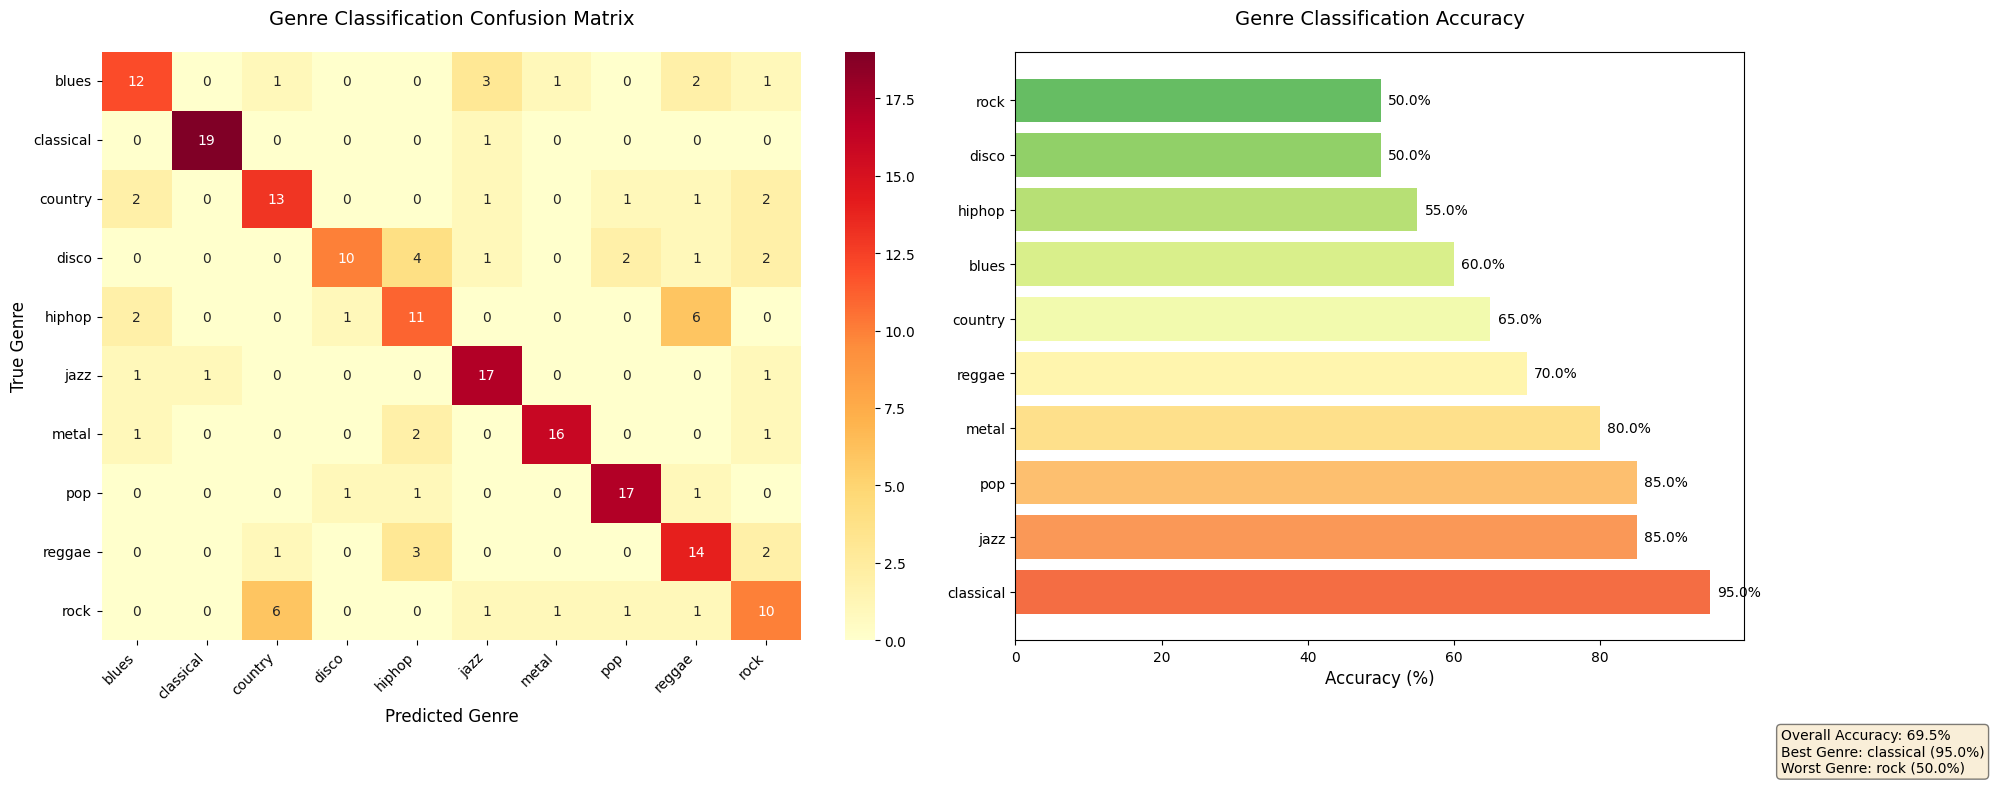

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def create_genre_analysis_plot(y_test, y_pred, genres):
    """
    Create a detailed visualization of genre classification results using a heatmap
    and performance metrics.
    
    Parameters:
    -----------
    y_test : array-like
        True labels
    y_pred : array-like
        Predicted labels
    genres : list
        List of genre names
    """
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 8))
    
    # Add gridspec to customize subplot layouts
    gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 1])
    
    # First subplot: Confusion Matrix Heatmap
    ax1 = fig.add_subplot(gs[0])
    cm = confusion_matrix(y_test, y_pred)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=genres, yticklabels=genres, ax=ax1)
    
    # Customize heatmap
    ax1.set_title('Genre Classification Confusion Matrix', pad=20, fontsize=14)
    ax1.set_xlabel('Predicted Genre', fontsize=12)
    ax1.set_ylabel('True Genre', fontsize=12)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.setp(ax1.get_yticklabels(), rotation=0)
    
    # Second subplot: Performance Metrics
    ax2 = fig.add_subplot(gs[1])
    
    # Calculate per-genre accuracy
    genre_accuracy = {}
    for genre in genres:
        mask = y_test == genre
        correct = np.sum((y_test == y_pred) & mask)
        total = np.sum(mask)
        genre_accuracy[genre] = (correct / total) * 100
    
    # Sort genres by accuracy
    sorted_genres = sorted(genre_accuracy.items(), key=lambda x: x[1], reverse=True)
    genres_sorted = [x[0] for x in sorted_genres]
    accuracy_sorted = [x[1] for x in sorted_genres]
    
    # Create horizontal bar plot
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(genres)))
    ax2.barh(genres_sorted, accuracy_sorted, color=colors)
    
    # Customize bar plot
    ax2.set_title('Genre Classification Accuracy', pad=20, fontsize=14)
    ax2.set_xlabel('Accuracy (%)', fontsize=12)
    
    # Add percentage labels on bars
    for i, v in enumerate(accuracy_sorted):
        ax2.text(v + 1, i, f'{v:.1f}%', va='center')
    
    # Add overall accuracy as text box
    overall_acc = np.mean(list(genre_accuracy.values()))
    textstr = f'Overall Accuracy: {overall_acc:.1f}%\n'
    textstr += f'Best Genre: {sorted_genres[0][0]} ({sorted_genres[0][1]:.1f}%)\n'
    textstr += f'Worst Genre: {sorted_genres[-1][0]} ({sorted_genres[-1][1]:.1f}%)'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(1.05, -0.15, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Example usage with sample data
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Create and display the plot
fig = create_genre_analysis_plot(y_test_set, results['predictions'], genres)
plt.show()

# Optional: Save the plot
# fig.savefig('genre_analysis.png', bbox_inches='tight', dpi=300)

### *Pickle File*

In [127]:
import pickle
# Saving file to a .pkl file

with open ('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Saving the preprocessor to a .pkl file
with open ('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# **Presenting The Solution**

## Music Genre Classification Analysis
### GTZAN Dataset Study 

### Executive Summary
Using the GTZAN dataset containing 1000 audio tracks across 10 genres, we developed a machine learning model to automatically classify music genres based on audio features. The model achieved 69.5% overall accuracy, with particularly strong performance in classical music classification (95% accuracy) and identified interesting patterns in genre-specific audio characteristics.

---

### Key Findings

#### 1. Genre Classification Performance

| **Genre**     | **Accuracy** | **Precision** | **F1-Score** |
|---------------|--------------|---------------|--------------|
| Classical     | 95.0%        | 0.95         | 0.95        |
| Jazz          | 85.0%        | 0.71         | 0.77        |
| Pop           | 85.0%        | 0.81         | 0.83        |
| Metal         | 80.0%        | 0.89         | 0.84        |
| Reggae        | 70.0%        | 0.54         | 0.61        |
| Country       | 65.0%        | 0.62         | 0.63        |
| Blues         | 60.0%        | 0.67         | 0.63        |
| Hip Hop       | 55.0%        | 0.52         | 0.54        |
| Disco         | 50.0%        | 0.83         | 0.62        |
| Rock          | 50.0%        | 0.53         | 0.51        |

#### 2. Audio Feature Analysis
- Classical music showed distinct spectral patterns
- Hip-hop and rock displayed unique RMS energy distributions
- Pop music demonstrated highest median brightness
- Metal and pop showed consistent frequency content

#### 3. Feature Importance
- MFCCs proved crucial for genre differentiation
- Spectral centroid effectively distinguished brightness levels
- RMS energy helped identify genre energy profiles
- Zero-crossing rate aided in genre separation

---

### Methods We Used

1. **Data Processing & Feature Extraction**
   - Librosa library for audio processing
   - Feature extraction from 30-second segments
   - Mel spectrograms and MFCCs computation
   - Custom preprocessing pipeline implementation

2. **Feature Engineering**
   - Audio feature extraction from raw files
   - Standardization of features by category
   - Additional ratio features creation
   - Mel spectrogram processing

3. **Model Development**
   - Tested 10 machine learning algorithms
   - Implemented cross-validation
   - Grid search for hyperparameter tuning
   - Custom evaluation metrics

---

### Model Performance

#### Training Metrics

| **Model**             | **Accuracy** | **Precision** | **Recall** |
|----------------------|--------------|---------------|------------|
| Gradient Boosting    | 99.88%       | 99.88%       | 99.88%    |
| Random Forest        | 99.88%       | 99.88%       | 99.88%    |
| Logistic Regression  | 87.00%       | 86.98%       | 87.00%    |
| SVC                  | 86.50%       | 86.97%       | 86.50%    |

#### Test Set Results
- Overall Accuracy: 69.5%
- Macro Average Precision: 0.71
- Macro Average Recall: 0.70
- Macro Average F1-Score: 0.69

#### Best Model Parameters (Logistic Regression)
- C: 1
- Penalty: 'l1'
- Solver: 'saga'
- Max iterations: 1000




